<a href="https://colab.research.google.com/github/DevasivaBA/DEV_Projects/blob/main/timber_mountain_Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timber Mountain A/B Test Analysis

As Timber Mountain explores digital enhancements to increase park ticket sales, this notebook evaluates the effectiveness of different website variations using A/B testing. We will:

- Clean and explore the data
- Calculate conversion rates and % lift
- Conduct Z-tests to determine statistical significance
- Analyze trip planner engagement
- Visualize the results and draw conclusions


In [1]:
# 📦 Step 1: Load and Clean the Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# Load dataset
df = pd.read_csv("/content/timber-mountain-experiment-data.csv")

# Convert to appropriate data types
df['visit_id'] = df['visit_id'].astype(str)
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' column is in datetime format
df['ticket_purchased'] = df['ticket_purchased'].astype(int)
df['trip_planner_engaged'] = df['trip_planner_engaged'].astype(int)

# Quick look at data
df.head()


,date,visit_id,treatment,trip_planner_engaged,ticket_purchased
0,2024-04-01,514882,variation_B,0,0
1,2024-04-01,514883,variation_B,1,0
2,2024-04-01,514884,variation_B,0,0
3,2024-04-01,514885,variation_B,0,0
4,2024-04-01,514886,variation_B,0,0


In [22]:
# Dataset Summary Overview
# Purpose: Generate high-level summary stats about the dataset for easy understanding

summary = {
    'Total Rows': len(df),
    'Date Range': f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}",
    'Unique Treatment Groups': df['treatment'].nunique(),
    'Treatment Sample Sizes': df['treatment'].value_counts().to_dict(),
    'Overall Conversion Rate (%)': round(df['ticket_purchased'].mean() * 100, 2),
    'Trip Planner Engagement Rate (%)': round(df['trip_planner_engaged'].mean() * 100, 2)
}

# Display summary in a cleaner tabular format
pd.DataFrame.from_dict(summary, orient='index', columns=['Value']).rename_axis("Metric").reset_index()



,Metric,Value
0,Total Rows,264948
1,Date Range,2024-04-01 to 2024-04-30
2,Unique Treatment Groups,3
3,Treatment Sample Sizes,"{'variation_B': 88570, 'control': 88266, 'vari..."
4,Overall Conversion Rate (%),2.24
5,Trip Planner Engagement Rate (%),22.76


In [23]:
# Z-Test Function

def ztest_statsmodels(success_variant, size_variant, success_control, size_control, alpha=0.05):
    '''
    Perform two-proportion Z-test using statsmodels.

    Args:
    - success_variant, size_variant: conversions and trials for variant group
    - success_control, size_control: conversions and trials for control group
    - alpha: significance level (default 0.05)

    Returns:
    - z_stat: Z test statistic (positive means variant > control)
    - p_val: P-value
    - significant: Boolean if statistically significant at given alpha
    '''
    count = np.array([success_variant, success_control])
    nobs = np.array([size_variant, size_control])
    z_stat, p_val = proportions_ztest(count, nobs)
    return round(z_stat, 3), round(p_val, 4), p_val < alpha



In [10]:
def format_ztest_results(z_results_dict):
    """
    Converts z-test results dictionary to a readable output table.
    """
    df = pd.DataFrame.from_dict(z_results_dict, orient='index')
    df.index.name = 'Treatment'
    df.reset_index(inplace=True)
    df['Significant at 95%'] = df['significant'].map({True: 'Yes', False: 'No'})
    df = df.rename(columns={
        'z_stat': 'Z-Statistic',
        'p_value': 'P-Value'
    })
    return df[['Treatment', 'Z-Statistic', 'P-Value', 'Significant at 95%']]


In [20]:
# Step 3: Calculate Conversion Rate and Lift Across All Treatments
# Objective: Compute the conversion rate (CVR) for each treatment group and quantify the lift vs. control

# Group by treatment group to calculate total visits and total purchases
conversion = df.groupby('treatment').agg(
    total_visits=('visit_id', 'count'),
    total_purchased=('ticket_purchased', 'sum')
)

# Calculate conversion rate as a percentage for each group
conversion['CVR (%)'] = round(
    (conversion['total_purchased'] / conversion['total_visits']) * 100, 2
)

# Extract the control group's CVR as baseline
control_cvr = conversion.loc['control', 'CVR (%)']

# Calculate % lift over control for each treatment
conversion['Lift vs Control (%)'] = round(
    ((conversion['CVR (%)'] - control_cvr) / control_cvr) * 100, 2
)

# Display the final summary table
conversion



,total_visits,total_purchased,CVR (%),Lift vs Control (%)
treatment,,,,
control,88266,1853,2.10,0.00
variation_A,88112,1982,2.25,7.14
variation_B,88570,2108,2.38,13.33


In [24]:
# Step 4: Z-Test Across Treatments
# Purpose: Determine if the conversion rates for variation_A and variation_B are significantly different from control

z_test_results = {}

# Loop through both variants and perform a Z-test against the control group
for variant in ['variation_A', 'variation_B']:
    # Fetch total conversions and total visitors for control and current variant
    z_stat, p_val, sig = ztest_statsmodels(
        conversion.loc[variant, 'total_purchased'],
        conversion.loc[variant, 'total_visits'],
        conversion.loc['control', 'total_purchased'],
        conversion.loc['control', 'total_visits']
    )

    # Store the result for this variant
    z_test_results[variant] = {
        'z_stat': z_stat,
        'p_value': p_val,
        'significant': sig
    }

# Display results in readable table format
format_ztest_results(z_test_results)



,Treatment,Z-Statistic,P-Value,Significant at 95%
0,variation_A,2.161,0.0307,Yes
1,variation_B,3.988,0.0001,Yes


<ipython-input-7-0d70df6fb7de>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion.index, y=conversion['CVR (%)'], ax=axs[0], palette="Blues_d")
<ipython-input-7-0d70df6fb7de>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion.index, y=conversion['Lift vs Control (%)'], ax=axs[1], palette="Greens_d")


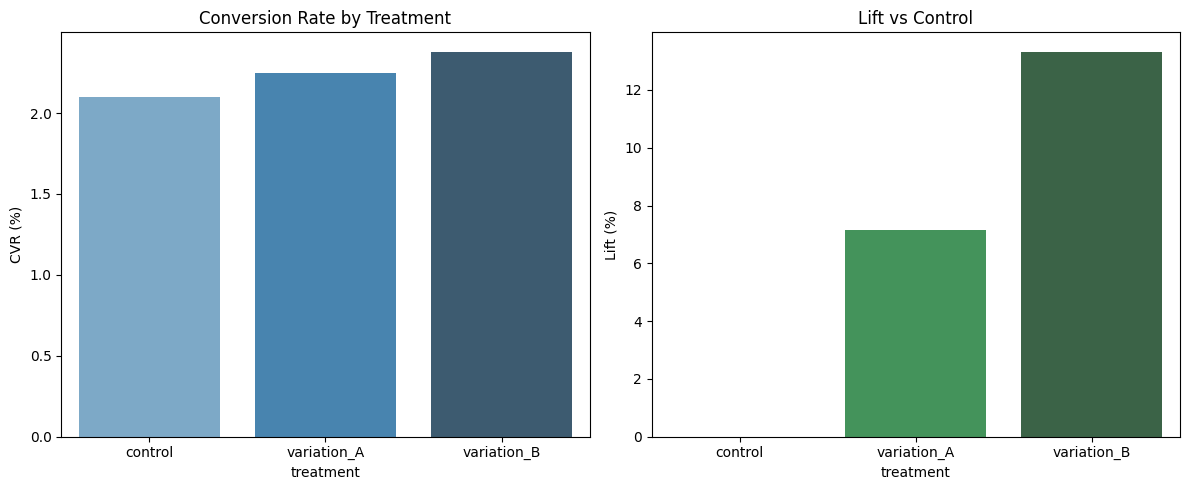

In [7]:
# Step 5: Visualize CVR and Lift

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=conversion.index, y=conversion['CVR (%)'], ax=axs[0], palette="Blues_d")
axs[0].set_title("Conversion Rate by Treatment")
axs[0].set_ylabel("CVR (%)")

sns.barplot(x=conversion.index, y=conversion['Lift vs Control (%)'], ax=axs[1], palette="Greens_d")
axs[1].set_title("Lift vs Control")
axs[1].set_ylabel("Lift (%)")

plt.tight_layout()
plt.show()


In [27]:
# Step 6: Analyze Conversion Rate Among Trip Planner Engaged Users
# Objective: Compare how well each variant performs "ONLY for users who engaged" with the trip planner

# Filter dataset to users who engaged with the trip planner, then group by treatment
trip_cvr = df[df['trip_planner_engaged'] == 1].groupby('treatment').agg(
    total_visits=('visit_id', 'count'),
    total_purchased=('ticket_purchased', 'sum')
).reset_index()

# Calculate conversion rate (CVR) for each group
trip_cvr['CVR (%)'] = round((trip_cvr['total_purchased'] / trip_cvr['total_visits']) * 100, 2)

# Identify the CVR of the control group (used as baseline for lift)
control_cvr = trip_cvr.loc[trip_cvr['treatment'] == 'control', 'CVR (%)'].values[0]

# Calculate lift vs. control for each variant
trip_cvr['Lift vs Control (%)'] = round(
    (trip_cvr['CVR (%)'] - control_cvr) / control_cvr * 100, 3
)

# Display results
trip_cvr



,treatment,total_visits,total_purchased,CVR (%),Lift vs Control (%)
0,control,11672,255,2.18,0.000
1,variation_A,24340,509,2.09,-4.128
2,variation_B,24286,552,2.27,4.128


In [26]:
# Z-Test: Trip Planner Engagement (engaged users only)
# Purpose: Compare engaged users' conversion rates in Variation A/B vs. Control using two-proportion z-test

engagement_z_tests = {}

# Loop through each variant and compare to control
for variant in ['variation_A', 'variation_B']:
    # Filter data to only include control and current variant, where users engaged with trip planner
    sub_df = df[(df['treatment'].isin(['control', variant])) & (df['trip_planner_engaged'] == 1)]

    # Group by treatment to get total purchases (sum) and total visits (count)
    summary = sub_df.groupby('treatment')['ticket_purchased'].agg(['sum', 'count'])

    # Perform z-test: variant first, control second (positive z = variant better)
    z_stat, p_val, sig = ztest_statsmodels(
        summary.loc[variant, 'sum'], summary.loc[variant, 'count'],
        summary.loc['control', 'sum'], summary.loc['control', 'count']
    )

    # Store test results for each variant
    engagement_z_tests[variant] = {
        'z_stat': z_stat,
        'p_value': p_val,
        'significant': sig
    }

# Display results in clean table format
format_ztest_results(engagement_z_tests)



,Treatment,Z-Statistic,P-Value,Significant at 95%
0,variation_A,-0.576,0.5644,No
1,variation_B,0.529,0.5970,No


## Final Summary and Recommendation

- **Variation B** outperformed other variants with a **13.3% lift** over the control group and statistically significant results.
- **Trip planner engagement did not result in statistically significant lift** in conversion for engaged users across groups.
- **Recommendation**: Adopt **Variation B** and re-evaluate how the trip planner can contribute more effectively to conversions.
